In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

set_name = 'DataSet01_300_950Hz_snap=5'
# Training Data
X_train = np.loadtxt( './data/' + set_name + '/SBCEx16_training_input.txt')
Y_train = np.loadtxt( './data/'+ set_name + '/training_labels.txt')
Range_train = np.loadtxt( './data/'+ set_name  + '/Mapping_range_labels.txt')

# Test Data
X_test = np.loadtxt( './data/'+ set_name + '/SBCEx16_test_input.txt')
Y_test = np.loadtxt( './data/'+ set_name + '/test_Ranges.txt')

In [77]:
Y_train2 = np.loadtxt( './data/'+ set_name + '/training_Ranges.txt')

In [78]:
import math

##### MAPE function

In [79]:
def MAPE(pred, y):
    # the pred here should be Z_out
    # the y should be y_test
    n = len(y)
    return sum(np.abs(pred - y) / y) / n

### (optional) Add noise - overfit

In [80]:
rand1 = np.random.randn(X_train.shape[0], X_train.shape[1]) * 0.17

In [81]:
X_train = X_train + rand1
rand2 = np.random.randn(X_test.shape[0], X_test.shape[1]) * 0.17
X_test = X_test + rand2

### feature selection

In [82]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [83]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, Y_train)
model = SelectFromModel(clf, prefit=True)

In [84]:
X_train2 = model.transform(X_train)
X_test2 = model.transform(X_test)

In [85]:
X_train2.shape

(890, 5718)

### FNN

In [41]:
import tensorflow as tf

##### data preprocessing - change the y_train to one hot

In [42]:
import numpy as np
y_train = np.zeros([len(Y_train), 144])
for i in range(0,len(Y_train)):
    temp=int(Y_train[i]-2)
    y_train[i,temp]=1

#y_train[np.arange(len(Y_train),int(Y_train))]=1

In [43]:
y_train.shape

(890, 144)

In [22]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

In [23]:
def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

#### Parameters for the model

In [24]:
n_in = X_train2.shape[1]
n_h1 = 256
n_cls = y_train.shape[1]

x = tf.placeholder(tf.float32, [None, n_in])
y = tf.placeholder(tf.float32, [None, n_cls])

In [25]:
def nn_model1(data):
    W1 = init_weights((n_in, n_h1))
    b1 = tf.Variable(tf.zeros([n_h1]))

    Wout = init_weights((n_h1, n_cls))
    bout = tf.Variable(tf.zeros([n_cls]))
    
    l1 = tf.matmul(data, W1) + b1
    l1 = tf.nn.relu(l1)
    
    pred = tf.nn.softmax(tf.matmul(l1, Wout) + bout)
    
    return pred

#### Parameters for the Training

In [19]:
batch_size = 50
n_eps = 50
disp_step = 10
learning_rate = 0.01

In [20]:
def train_nn1(data):
    pred = nn_model1(data)
    cost = -tf.reduce_sum(y*tf.log(tf.clip_by_value(pred,1e-11,1.0)))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    epochs = n_eps
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        #prev_loss = None
        
        for epoch in range(epochs):
            avg_cost = 0
            total_batch = int(X_train2.shape[0] / batch_size)
            
            # Training
            for i in range(total_batch):
                xb = X_train2[i * batch_size : (i + 1) * batch_size]
                yb = y_train[i * batch_size : (i + 1) * batch_size]
                _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                avg_cost += c / total_batch
            
            if (epoch+1) % disp_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            if math.isnan(avg_cost):
                break
            #prev_loss = loss
        print 'training finished!'
        predictions = sess.run(pred, feed_dict = {x: X_test2})
            
        
        print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
    return predictions
    
        #correct = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        #accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        #print(sess.run(accuracy, feed_dict = \
        #               {x: mnist.test.images, y: mnist.test.labels}))

In [21]:
pred1 = train_nn1(x)

('Epoch:', '0010', 'cost=', '2.443913039')
('Epoch:', '0020', 'cost=', '0.221644135')
('Epoch:', '0030', 'cost=', '0.107316787')
('Epoch:', '0040', 'cost=', '0.064163844')
('Epoch:', '0050', 'cost=', '0.042782144')
training finished!
('accuarcy(train) =', 0.96158195)


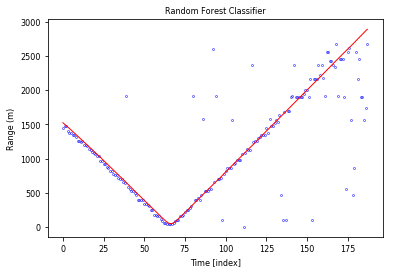

0.191517162118


In [22]:
Z=np.argmax(pred1,1)
Z_out = Range_train[Z.astype(np.int32)]

plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title('Random Forest Classifier',fontsize=8)

plt.show()
print MAPE(Z_out, Y_test)

In [23]:
Z_out_l1 = Z_out

#### get the plot

#### 2 layers FNN

In [122]:
n_in = X_train2.shape[1]
n_h1 = 256
n_h2 = 256
n_cls = y_train.shape[1]

x = tf.placeholder(tf.float32, [None, n_in])
y = tf.placeholder(tf.float32, [None, n_cls])

In [123]:
def nn_model2(data, beta):
    W1 = init_weights((n_in, n_h1))
    b1 = tf.Variable(tf.zeros([n_h1]))
    
    W2 = init_weights((n_h1, n_h2))
    b2 = tf.Variable(tf.zeros([n_h2]))

    Wout = init_weights((n_h2, n_cls))
    bout = tf.Variable(tf.zeros([n_cls]))
    
    l1 = tf.matmul(data, W1) + b1
    l1 = tf.nn.relu(l1)
    
    l2 = tf.matmul(l1, W2) + b2
    l2 = tf.nn.relu(l2)
    
    pred = tf.nn.softmax(tf.matmul(l2, Wout) + bout)
    
    reg = beta*tf.nn.l2_loss(W1) + \
        beta*tf.nn.l2_loss(b1) + \
        beta*tf.nn.l2_loss(W2) + \
        beta*tf.nn.l2_loss(b2) + \
        beta*tf.nn.l2_loss(Wout) + \
        beta*tf.nn.l2_loss(bout)
    return pred, reg

In [136]:
batch_size = 50
n_eps = 75
disp_step = 10
learning_rate = 0.004
# regularization 
beta = 0.0001

In [137]:
def train_nn2(data):
    pred, reg = nn_model2(data, beta)
    cost = tf.reduce_sum(-y*tf.log(tf.clip_by_value(pred,1e-11,1.0)) + reg)
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
    #    logits = pred, labels = y))
                           
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    epochs = n_eps
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        #prev_loss = None
        
        for epoch in range(epochs):
            avg_cost = 0
            total_batch = int(X_train2.shape[0] / batch_size)
            
            # Training
            for i in range(total_batch):
                xb = X_train2[i * batch_size : (i + 1) * batch_size]
                yb = y_train[i * batch_size : (i + 1) * batch_size]
                _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                avg_cost += c / total_batch
            
            if (epoch+1) % disp_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            if math.isnan(avg_cost):
                break
            #prev_loss = loss
        print 'training finished!'
        predictions = sess.run(pred, feed_dict = {x: X_test2})
            
        
        print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
    return predictions
    
        #correct = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        #accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        #print(sess.run(accuracy, feed_dict = \
        #               {x: mnist.test.images, y: mnist.test.labels}))

In [ ]:
pred2 = train_nn2(x)

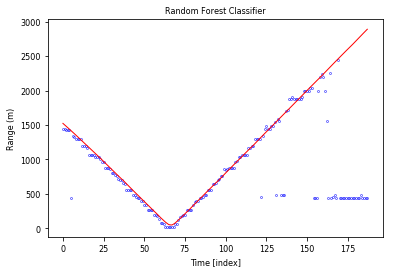

0.204116251035


In [139]:
Z=np.argmax(pred2,1)
Z_out = Range_train[Z.astype(np.int32)]

plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title('Random Forest Classifier',fontsize=8)

plt.show()
print MAPE(Z_out, Y_test)

##### Tuning the 2-layers FNN

beta =  1e-05 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '340.558647605')
('Epoch:', '0020', 'cost=', '254.776920094')
('Epoch:', '0030', 'cost=', '180.387951122')
('Epoch:', '0040', 'cost=', '124.108261108')
('Epoch:', '0050', 'cost=', '89.734704859')
training finished!
('accuarcy(train) =', 0.93446326)


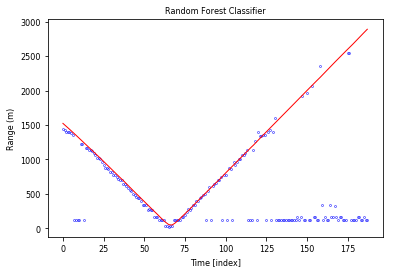

0.381679599408
beta =  1e-05 learning rate =  0.001
('Epoch:', '0010', 'cost=', '269.770981733')
('Epoch:', '0020', 'cost=', '146.759550207')
('Epoch:', '0030', 'cost=', '92.648208169')
('Epoch:', '0040', 'cost=', '60.167838377')
('Epoch:', '0050', 'cost=', '43.826382805')
training finished!
('accuarcy(train) =', 0.95819211)


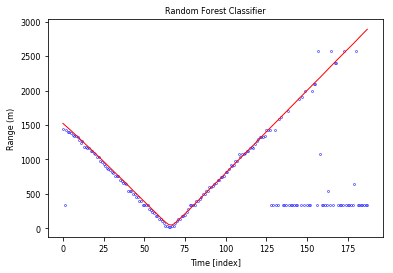

0.245960694326
beta =  1e-05 learning rate =  0.002
('Epoch:', '0010', 'cost=', '187.284528844')
('Epoch:', '0020', 'cost=', '96.235121783')
('Epoch:', '0030', 'cost=', '57.301796633')
('Epoch:', '0040', 'cost=', '60.383640289')
('Epoch:', '0050', 'cost=', '37.220195097')
training finished!
('accuarcy(train) =', 0.94689268)


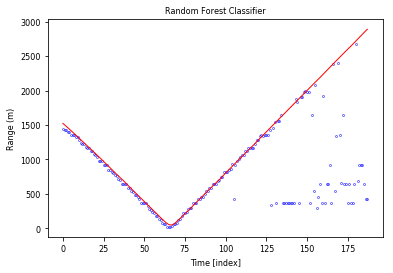

0.217228912611
beta =  1e-05 learning rate =  0.004
('Epoch:', '0010', 'cost=', '114.450161653')
('Epoch:', '0020', 'cost=', '86.532686121')
('Epoch:', '0030', 'cost=', '62.825563543')
('Epoch:', '0040', 'cost=', '68.636178185')
('Epoch:', '0050', 'cost=', '64.950873431')
training finished!
('accuarcy(train) =', 0.91073447)


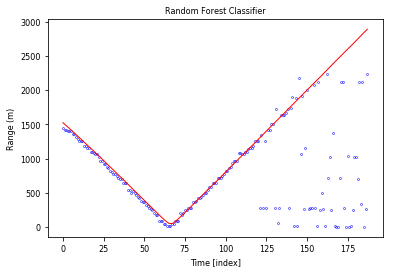

0.248529873534
beta =  1e-05 learning rate =  0.0075
('Epoch:', '0010', 'cost=', '130.015552296')
('Epoch:', '0020', 'cost=', '106.412571178')
('Epoch:', '0030', 'cost=', '97.808228885')
('Epoch:', '0040', 'cost=', '106.976535573')
('Epoch:', '0050', 'cost=', '111.666075314')
training finished!
('accuarcy(train) =', 0.81242937)


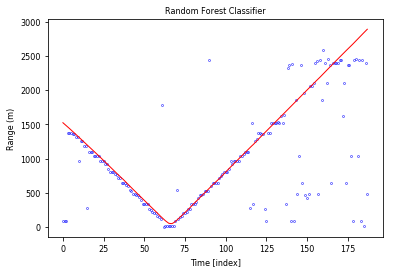

0.299411785822
beta =  1e-05 learning rate =  0.01
('Epoch:', '0010', 'cost=', '188.634418263')
('Epoch:', '0020', 'cost=', '135.085353627')
('Epoch:', '0030', 'cost=', '115.416186164')
('Epoch:', '0040', 'cost=', '105.085129233')
('Epoch:', '0050', 'cost=', '99.607750837')
training finished!
('accuarcy(train) =', 0.83050847)


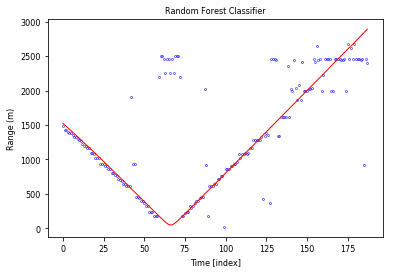

2.19249455854
beta =  5e-05 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '1045.024421243')
('Epoch:', '0020', 'cost=', '479.543891458')
('Epoch:', '0030', 'cost=', '243.338509952')
('Epoch:', '0040', 'cost=', '153.731807933')
('Epoch:', '0050', 'cost=', '119.051633947')
training finished!
('accuarcy(train) =', 0.95932204)


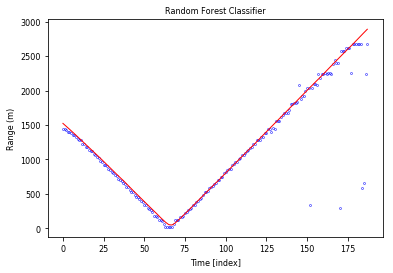

0.0763927821608
beta =  5e-05 learning rate =  0.001
('Epoch:', '0010', 'cost=', '511.308010326')
('Epoch:', '0020', 'cost=', '177.293106079')
('Epoch:', '0030', 'cost=', '121.223087086')
('Epoch:', '0040', 'cost=', '105.913245257')
('Epoch:', '0050', 'cost=', '99.897868886')
training finished!
('accuarcy(train) =', 0.92090398)


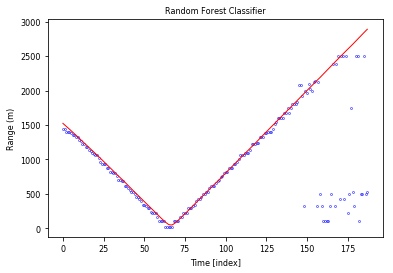

0.16412040254
beta =  5e-05 learning rate =  0.002
('Epoch:', '0010', 'cost=', '219.022863949')
('Epoch:', '0020', 'cost=', '125.536670012')
('Epoch:', '0030', 'cost=', '119.916166867')
('Epoch:', '0040', 'cost=', '114.664822298')
('Epoch:', '0050', 'cost=', '110.471042409')
training finished!
('accuarcy(train) =', 0.8418079)


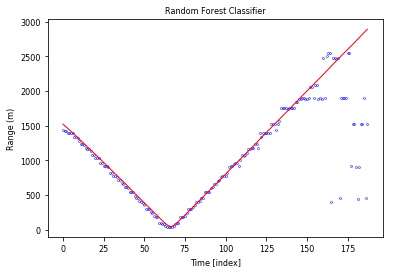

0.101912933051
beta =  5e-05 learning rate =  0.004
('Epoch:', '0010', 'cost=', '171.814421710')
('Epoch:', '0020', 'cost=', '152.934941909')
('Epoch:', '0030', 'cost=', '138.859982659')
('Epoch:', '0040', 'cost=', '132.087203979')
('Epoch:', '0050', 'cost=', '119.902225270')
training finished!
('accuarcy(train) =', 0.7615819)


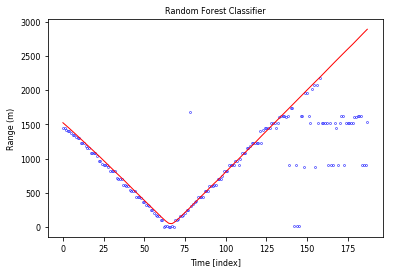

0.199795488251
beta =  5e-05 learning rate =  0.0075
('Epoch:', '0010', 'cost=', '217.724570779')
('Epoch:', '0020', 'cost=', '171.220328387')
('Epoch:', '0030', 'cost=', '160.258874781')
('Epoch:', '0040', 'cost=', '147.953573339')
('Epoch:', '0050', 'cost=', '139.787538865')
training finished!
('accuarcy(train) =', 0.60903955)


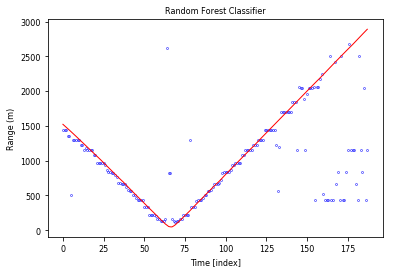

0.540913030114
beta =  5e-05 learning rate =  0.01
('Epoch:', '0010', 'cost=', '224.918562945')
('Epoch:', '0020', 'cost=', '213.875722549')
('Epoch:', '0030', 'cost=', '184.617321239')
('Epoch:', '0040', 'cost=', '170.520140704')
('Epoch:', '0050', 'cost=', '175.892548505')
training finished!
('accuarcy(train) =', 0.62259889)


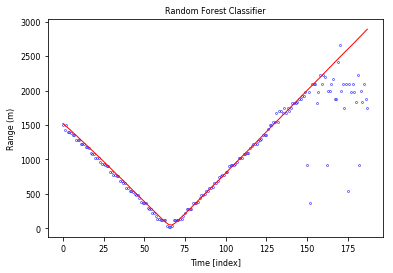

0.100608223972
beta =  0.0001 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '1633.186063879')
('Epoch:', '0020', 'cost=', '651.463378906')
('Epoch:', '0030', 'cost=', '323.489582735')
('Epoch:', '0040', 'cost=', '214.976994234')
('Epoch:', '0050', 'cost=', '175.405097513')
training finished!
('accuarcy(train) =', 0.95932204)


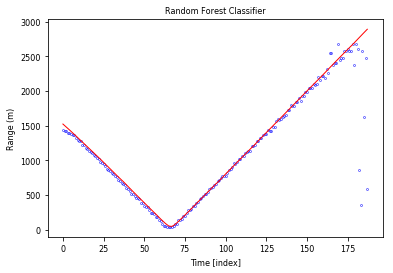

0.0609054017643
beta =  0.0001 learning rate =  0.001
('Epoch:', '0010', 'cost=', '667.925368365')
('Epoch:', '0020', 'cost=', '225.329725378')
('Epoch:', '0030', 'cost=', '170.495206945')
('Epoch:', '0040', 'cost=', '154.700417014')
('Epoch:', '0050', 'cost=', '149.738434735')
training finished!
('accuarcy(train) =', 0.87457627)


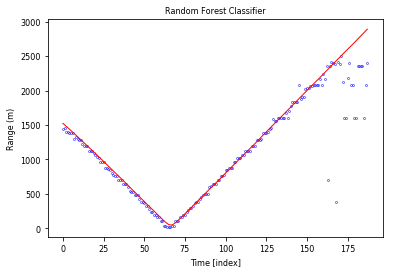

0.0854994660504
beta =  0.0001 learning rate =  0.002
('Epoch:', '0010', 'cost=', '244.960477941')
('Epoch:', '0020', 'cost=', '178.513056138')
('Epoch:', '0030', 'cost=', '172.618686452')
('Epoch:', '0040', 'cost=', '165.375061933')
('Epoch:', '0050', 'cost=', '160.228603587')
training finished!
('accuarcy(train) =', 0.74689263)


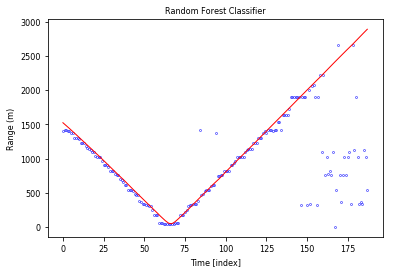

0.197275462326
beta =  0.0001 learning rate =  0.004
('Epoch:', '0010', 'cost=', '230.321632834')
('Epoch:', '0020', 'cost=', '194.556740256')
('Epoch:', '0030', 'cost=', '175.790389117')
('Epoch:', '0040', 'cost=', '172.284086340')
('Epoch:', '0050', 'cost=', '162.550943711')
training finished!
('accuarcy(train) =', 0.67005652)


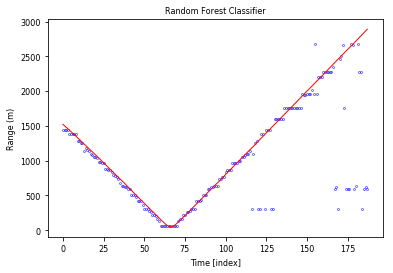

0.136602900463
beta =  0.0001 learning rate =  0.0075
('Epoch:', '0010', 'cost=', '258.511013255')
('Epoch:', '0020', 'cost=', '227.171583288')
('Epoch:', '0030', 'cost=', '210.990071914')
('Epoch:', '0040', 'cost=', '201.118127262')
('Epoch:', '0050', 'cost=', '215.968227611')
training finished!
('accuarcy(train) =', 0.52655369)


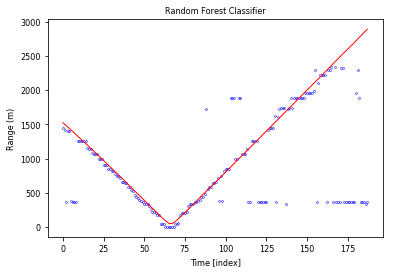

0.275109067684
beta =  0.0001 learning rate =  0.01
('Epoch:', '0010', 'cost=', '276.825304817')
('Epoch:', '0020', 'cost=', '267.497181612')
('Epoch:', '0030', 'cost=', '236.809498506')
('Epoch:', '0040', 'cost=', '218.653384040')
('Epoch:', '0050', 'cost=', '201.921070772')
training finished!
('accuarcy(train) =', 0.48474577)


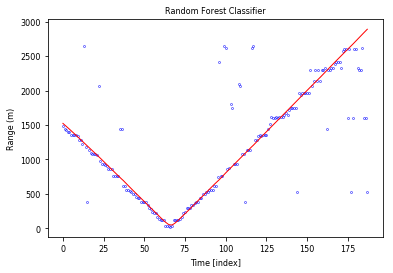

0.184340373774
beta =  0.0002 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '2693.798914292')
('Epoch:', '0020', 'cost=', '971.737225701')
('Epoch:', '0030', 'cost=', '464.284290987')
('Epoch:', '0040', 'cost=', '304.887431425')
('Epoch:', '0050', 'cost=', '248.881099925')
training finished!
('accuarcy(train) =', 0.87231636)


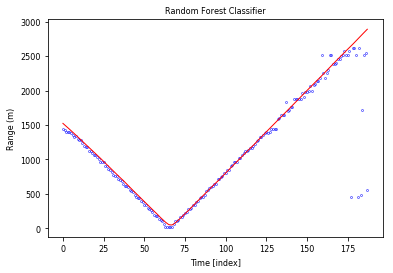

0.0776053513091
beta =  0.0002 learning rate =  0.001
('Epoch:', '0010', 'cost=', '975.259266573')
('Epoch:', '0020', 'cost=', '304.946542179')
('Epoch:', '0030', 'cost=', '227.964718089')
('Epoch:', '0040', 'cost=', '215.039218678')
('Epoch:', '0050', 'cost=', '207.666743559')
training finished!
('accuarcy(train) =', 0.73785311)


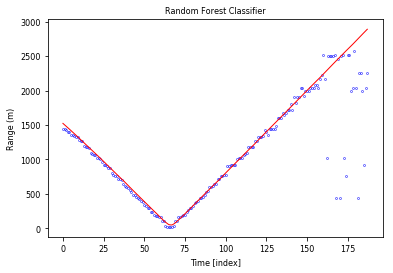

0.094851783227
beta =  0.0002 learning rate =  0.002
('Epoch:', '0010', 'cost=', '314.288866828')
('Epoch:', '0020', 'cost=', '234.102570478')
('Epoch:', '0030', 'cost=', '219.009319530')
('Epoch:', '0040', 'cost=', '215.685909496')
('Epoch:', '0050', 'cost=', '214.109151504')
training finished!
('accuarcy(train) =', 0.4960452)


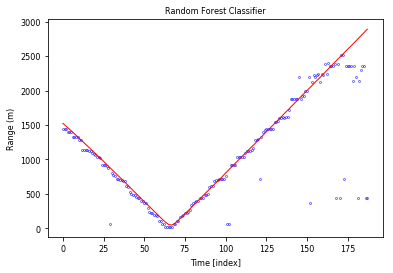

0.123445608325
beta =  0.0002 learning rate =  0.004
('Epoch:', '0010', 'cost=', '257.703251558')
('Epoch:', '0020', 'cost=', '237.385221594')
('Epoch:', '0030', 'cost=', '236.480875352')
('Epoch:', '0040', 'cost=', '222.274320715')
('Epoch:', '0050', 'cost=', '217.929587869')
training finished!
('accuarcy(train) =', 0.42711863)


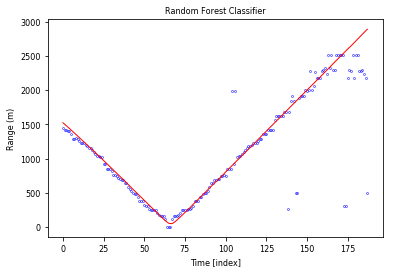

0.137488428748
beta =  0.0002 learning rate =  0.0075
('Epoch:', '0010', 'cost=', '246.910720825')
('Epoch:', '0020', 'cost=', '239.102032830')
('Epoch:', '0030', 'cost=', '240.431682811')
('Epoch:', '0040', 'cost=', '238.354247149')
('Epoch:', '0050', 'cost=', '238.064605713')
training finished!
('accuarcy(train) =', 0.044067796)


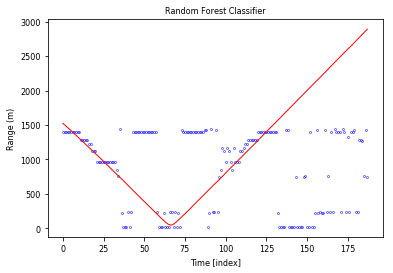

0.956045340363
beta =  0.0002 learning rate =  0.01
('Epoch:', '0010', 'cost=', '247.750341079')
('Epoch:', '0020', 'cost=', '247.715549245')
('Epoch:', '0030', 'cost=', '247.714412914')
('Epoch:', '0040', 'cost=', '247.716864193')
('Epoch:', '0050', 'cost=', '247.720638500')
training finished!
('accuarcy(train) =', 0.013559322)


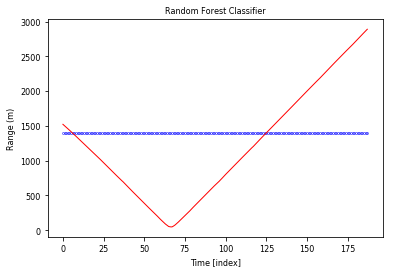

2.06430169665
beta =  0.0004 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '4893.915527344')
('Epoch:', '0020', 'cost=', '1575.365672392')
('Epoch:', '0030', 'cost=', '640.884079877')
('Epoch:', '0040', 'cost=', '367.872314453')
('Epoch:', '0050', 'cost=', '286.078531602')
training finished!
('accuarcy(train) =', 0.11525424)


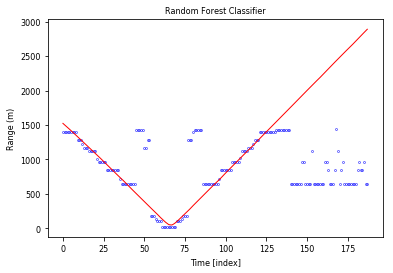

0.511232182401
beta =  0.0004 learning rate =  0.001
('Epoch:', '0010', 'cost=', '1561.427037856')
('Epoch:', '0020', 'cost=', '360.937358183')
('Epoch:', '0030', 'cost=', '259.560098985')
('Epoch:', '0040', 'cost=', '249.161302454')
('Epoch:', '0050', 'cost=', '248.157916798')
training finished!
('accuarcy(train) =', 0.073446326)


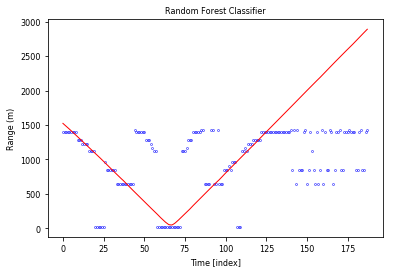

0.739117193625
beta =  0.0004 learning rate =  0.002
('Epoch:', '0010', 'cost=', '351.502622717')
('Epoch:', '0020', 'cost=', '250.692077637')
('Epoch:', '0030', 'cost=', '249.169610416')
('Epoch:', '0040', 'cost=', '248.964917351')
('Epoch:', '0050', 'cost=', '248.820124009')
training finished!
('accuarcy(train) =', 0.013559322)


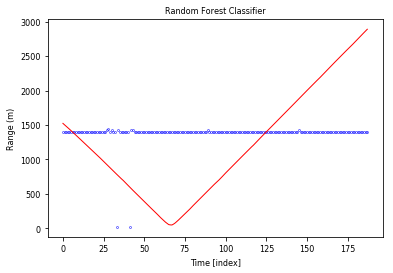

2.06447435593
beta =  0.0004 learning rate =  0.004
('Epoch:', '0010', 'cost=', '248.717767154')
('Epoch:', '0020', 'cost=', '248.032196942')
('Epoch:', '0030', 'cost=', '248.024382647')
('Epoch:', '0040', 'cost=', '248.026056626')
('Epoch:', '0050', 'cost=', '248.027615715')
training finished!
('accuarcy(train) =', 0.013559322)


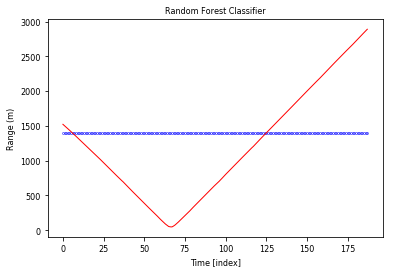

2.06430169665
beta =  0.0004 learning rate =  0.0075
('Epoch:', '0010', 'cost=', '248.114315257')
('Epoch:', '0020', 'cost=', '248.104348575')
('Epoch:', '0030', 'cost=', '248.103201473')
('Epoch:', '0040', 'cost=', '248.102933996')
('Epoch:', '0050', 'cost=', '248.103119794')
training finished!
('accuarcy(train) =', 0.013559322)


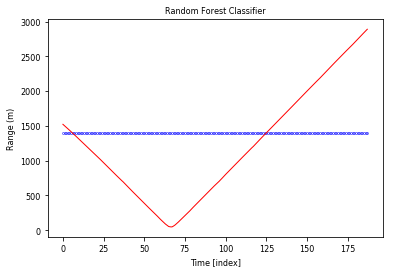

2.06430169665
beta =  0.0004 learning rate =  0.01
('Epoch:', '0010', 'cost=', '248.164005953')
('Epoch:', '0020', 'cost=', '248.160499124')
('Epoch:', '0030', 'cost=', '248.161372465')
('Epoch:', '0040', 'cost=', '248.171260161')
('Epoch:', '0050', 'cost=', '248.161586986')
training finished!
('accuarcy(train) =', 0.013559322)


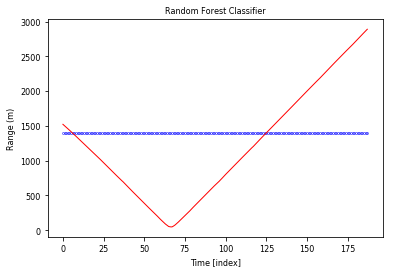

2.06430169665
beta =  0.0008 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '9244.632180607')
('Epoch:', '0020', 'cost=', '2723.853056066')
('Epoch:', '0030', 'cost=', '932.459386489')
('Epoch:', '0040', 'cost=', '435.750700109')
('Epoch:', '0050', 'cost=', '298.889217601')
training finished!
('accuarcy(train) =', 0.013559322)


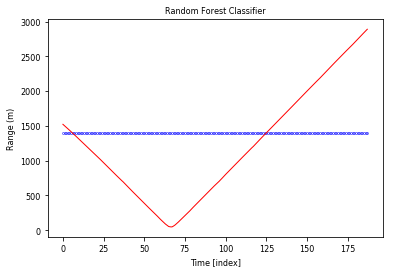

2.06430169665
beta =  0.0008 learning rate =  0.001
('Epoch:', '0010', 'cost=', '2738.113597197')
('Epoch:', '0020', 'cost=', '436.154041963')
('Epoch:', '0030', 'cost=', '262.759794347')
('Epoch:', '0040', 'cost=', '249.367583331')
('Epoch:', '0050', 'cost=', '248.312940710')
training finished!
('accuarcy(train) =', 0.013559322)


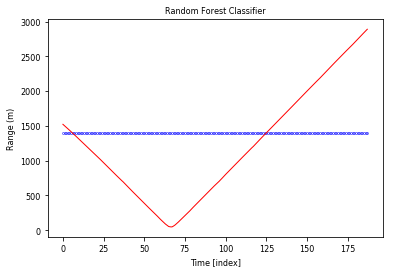

2.06430169665
beta =  0.0008 learning rate =  0.002
('Epoch:', '0010', 'cost=', '421.904181985')
('Epoch:', '0020', 'cost=', '249.215856216')
('Epoch:', '0030', 'cost=', '248.247875438')
('Epoch:', '0040', 'cost=', '248.243093154')
('Epoch:', '0050', 'cost=', '248.241976570')
training finished!
('accuarcy(train) =', 0.013559322)


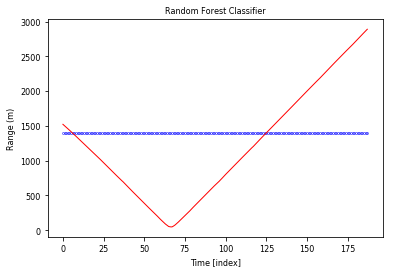

2.06430169665
beta =  0.0008 learning rate =  0.004
('Epoch:', '0010', 'cost=', '248.799225751')
('Epoch:', '0020', 'cost=', '248.289936739')
('Epoch:', '0030', 'cost=', '248.288738475')
('Epoch:', '0040', 'cost=', '248.288584092')
('Epoch:', '0050', 'cost=', '248.288554472')
training finished!
('accuarcy(train) =', 0.013559322)


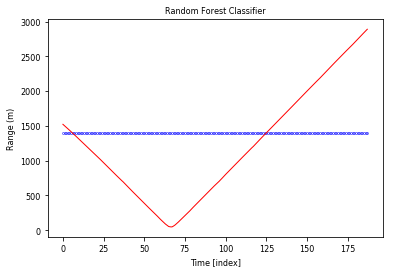

2.06430169665
beta =  0.0008 learning rate =  0.0075
('Epoch:', '0010', 'cost=', '248.367090562')
('Epoch:', '0020', 'cost=', '248.366205552')
('Epoch:', '0030', 'cost=', '248.366204654')
('Epoch:', '0040', 'cost=', '248.366218118')
('Epoch:', '0050', 'cost=', '248.366224401')
training finished!
('accuarcy(train) =', 0.013559322)


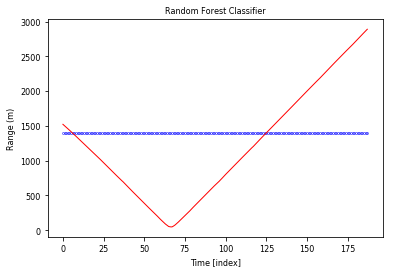

2.06430169665
beta =  0.0008 learning rate =  0.01
('Epoch:', '0010', 'cost=', '248.426955279')
('Epoch:', '0020', 'cost=', '248.426675236')
('Epoch:', '0030', 'cost=', '248.426737168')
('Epoch:', '0040', 'cost=', '248.426771276')
('Epoch:', '0050', 'cost=', '248.426803589')
training finished!
('accuarcy(train) =', 0.013559322)


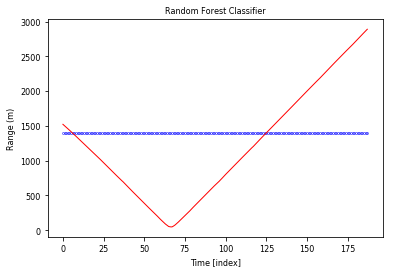

2.06430169665


In [187]:
for beta in [0.00001, 0.00005, 0.0001, 0.0002, 0.0004, 0.0008]:
    for learning_rate in [0.0001, 0.00025, 0.0005, 0.001]:
        print 'beta = ', beta, 'learning rate = ', learning_rate
        def train_nn2(data):
            pred, reg = nn_model2(data, beta)
            cost = tf.reduce_sum(-y*tf.log(tf.clip_by_value(pred,1e-11,1.0)) + reg)
            #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
            #    logits = pred, labels = y))

            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

            # Test model
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            # Calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            epochs = n_eps

            with tf.Session() as sess:
                tf.global_variables_initializer().run()
                #prev_loss = None

                for epoch in range(epochs):
                    avg_cost = 0
                    total_batch = int(X_train2.shape[0] / batch_size)

                    # Training
                    for i in range(total_batch):
                        xb = X_train2[i * batch_size : (i + 1) * batch_size]
                        yb = y_train[i * batch_size : (i + 1) * batch_size]
                        _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                        avg_cost += c / total_batch

                    if (epoch+1) % disp_step == 0:
                        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
                    if math.isnan(avg_cost):
                        break
                    #prev_loss = loss
                print 'training finished!'
                predictions = sess.run(pred, feed_dict = {x: X_test2})


                print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
            return predictions

        pred2 = train_nn2(x)
        Z=np.argmax(pred2,1)
        Z_out = Range_train[Z.astype(np.int32)]

        plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
        plt.plot(Y_test,'r',linewidth=1.0)

        plt.xlabel('Time [index]',fontsize=8)
        plt.ylabel('Range (m)',fontsize=8)
        plt.tick_params(axis='both', which='major', labelsize=8)
        plt.tick_params(axis='both', which='minor', labelsize=8)
        plt.title('Random Forest Classifier',fontsize=8)

        plt.show()
        print MAPE(Z_out, Y_test)

_optimal params_:   
beta = 0.0001 learning_rate = 0.0005  

beta = 5e-5   learning_rate = 0.0005  

beta = 0.0002 learning_rate = 0.0005

#### 3 layers FNN

In [188]:
n_in = X_train2.shape[1]
n_h1 = 256
n_h2 = 256
n_h3 = 256
n_cls = y_train.shape[1]

x = tf.placeholder(tf.float32, [None, n_in])
y = tf.placeholder(tf.float32, [None, n_cls])

In [142]:
def nn_model3(data, beta):
    W1 = init_weights((n_in, n_h1))
    b1 = tf.Variable(tf.zeros([n_h1]))
    
    W2 = init_weights((n_h1, n_h2))
    b2 = tf.Variable(tf.zeros([n_h2]))
    
    W3 = init_weights((n_h2, n_h3))
    b3 = tf.Variable(tf.zeros([n_h3]))

    Wout = init_weights((n_h3, n_cls))
    bout = tf.Variable(tf.zeros([n_cls]))
    
    l1 = tf.matmul(data, W1) + b1
    l1 = tf.nn.relu(l1)
    
    l2 = tf.matmul(l1, W2) + b2
    l2 = tf.nn.relu(l2)
    
    l3 = tf.matmul(l2, W3) + b3
    l3 = tf.nn.relu(l3)
    
    pred = tf.nn.softmax(tf.matmul(l3, Wout) + bout)
    
    reg = beta*tf.nn.l2_loss(W1) + \
        beta*tf.nn.l2_loss(b1) + \
        beta*tf.nn.l2_loss(W2) + \
        beta*tf.nn.l2_loss(b2) + \
        beta*tf.nn.l2_loss(W3) + \
        beta*tf.nn.l2_loss(b3) + \
        beta*tf.nn.l2_loss(Wout) + \
        beta*tf.nn.l2_loss(bout)
    return pred, reg

In [189]:
batch_size = 50
n_eps = 75
disp_step = 10
learning_rate = 0.002
# regularization 
beta = 0.00001

In [175]:
def train_nn3(data):
    pred, reg = nn_model3(data, beta)
    cost = tf.reduce_sum(-y*tf.log(tf.clip_by_value(pred,1e-11,1.0)) + reg)
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
    #    logits = pred, labels = y))
                           
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    epochs = n_eps
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        #prev_loss = None
        
        for epoch in range(epochs):
            avg_cost = 0
            total_batch = int(X_train2.shape[0] / batch_size)
            
            # Training
            for i in range(total_batch):
                xb = X_train2[i * batch_size : (i + 1) * batch_size]
                yb = y_train[i * batch_size : (i + 1) * batch_size]
                _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                avg_cost += c / total_batch
            
            if (epoch+1) % disp_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            if math.isnan(avg_cost):
                break
            #prev_loss = loss
        print 'training finished!'
        predictions = sess.run(pred, feed_dict = {x: X_test2})
            
        
        print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
    return predictions
    
        #correct = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        #accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        #print(sess.run(accuracy, feed_dict = \
        #               {x: mnist.test.images, y: mnist.test.labels}))

In [178]:
pred3 = train_nn3(x)

('Epoch:', '0010', 'cost=', '228.345561308')
('Epoch:', '0020', 'cost=', '138.747176226')
('Epoch:', '0030', 'cost=', '76.147118064')
('Epoch:', '0040', 'cost=', '97.056398728')
('Epoch:', '0050', 'cost=', '58.676947874')
('Epoch:', '0060', 'cost=', '74.617632922')
('Epoch:', '0070', 'cost=', '45.379528943')
training finished!
('accuarcy(train) =', 0.89152545)


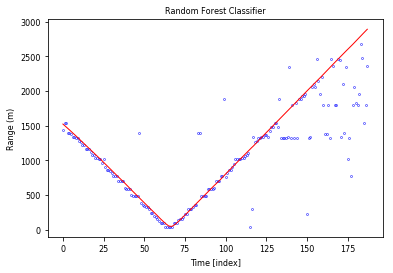

0.167815009784


In [179]:
Z=np.argmax(pred3,1)
Z_out = Range_train[Z.astype(np.int32)]

plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title('Random Forest Classifier',fontsize=8)

plt.show()
print MAPE(Z_out, Y_test)

beta =  1e-05 learning rate =  5e-05
('Epoch:', '0010', 'cost=', '620.033468807')
('Epoch:', '0020', 'cost=', '548.760282629')
('Epoch:', '0030', 'cost=', '464.981416590')
('Epoch:', '0040', 'cost=', '416.413365981')
('Epoch:', '0050', 'cost=', '397.495176428')
('Epoch:', '0060', 'cost=', '385.740991929')
('Epoch:', '0070', 'cost=', '375.192460004')
training finished!
('accuarcy(train) =', 0.96158195)


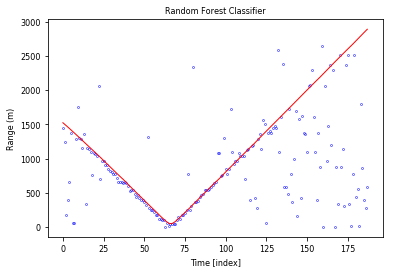

0.323696482452
beta =  1e-05 learning rate =  0.0001
('Epoch:', '0010', 'cost=', '554.351716883')
('Epoch:', '0020', 'cost=', '420.936369054')
('Epoch:', '0030', 'cost=', '387.714328541')
('Epoch:', '0040', 'cost=', '367.891913919')
('Epoch:', '0050', 'cost=', '348.007688635')
('Epoch:', '0060', 'cost=', '327.342917050')
('Epoch:', '0070', 'cost=', '306.057649500')
training finished!
('accuarcy(train) =', 0.96158195)


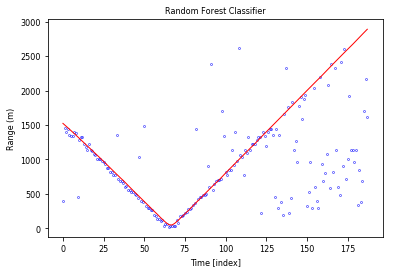

0.292146714171
beta =  1e-05 learning rate =  0.00025
('Epoch:', '0010', 'cost=', '401.580074535')
('Epoch:', '0020', 'cost=', '349.210135067')
('Epoch:', '0030', 'cost=', '300.532088336')
('Epoch:', '0040', 'cost=', '252.692118925')
('Epoch:', '0050', 'cost=', '208.568558637')
('Epoch:', '0060', 'cost=', '169.806090411')
('Epoch:', '0070', 'cost=', '137.043955186')
training finished!
('accuarcy(train) =', 0.96158195)


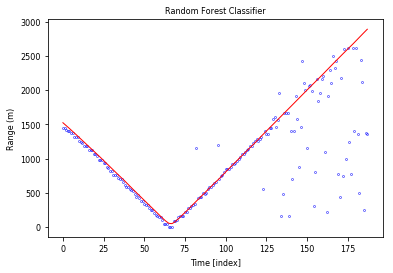

0.170366489821
beta =  1e-05 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '363.335262523')
('Epoch:', '0020', 'cost=', '275.313137279')
('Epoch:', '0030', 'cost=', '200.197262035')
('Epoch:', '0040', 'cost=', '141.539193546')
('Epoch:', '0050', 'cost=', '126.844524608')
('Epoch:', '0060', 'cost=', '83.014749415')
('Epoch:', '0070', 'cost=', '65.768374724')
training finished!
('accuarcy(train) =', 0.96158195)


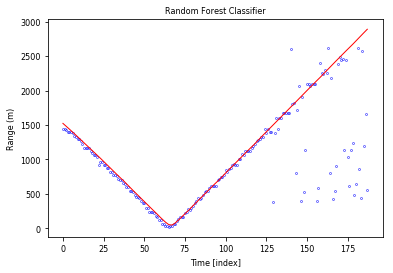

0.142648126213
beta =  1e-05 learning rate =  0.001
('Epoch:', '0010', 'cost=', '300.721116010')
('Epoch:', '0020', 'cost=', '186.584783217')
('Epoch:', '0030', 'cost=', '135.431008732')
('Epoch:', '0040', 'cost=', '86.296993480')
('Epoch:', '0050', 'cost=', '73.763005874')
('Epoch:', '0060', 'cost=', '49.853486678')
('Epoch:', '0070', 'cost=', '54.481625052')
training finished!
('accuarcy(train) =', 0.96045196)


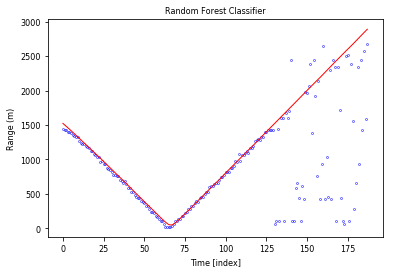

0.188319758387
beta =  5e-05 learning rate =  5e-05
('Epoch:', '0010', 'cost=', '2188.096909467')
('Epoch:', '0020', 'cost=', '2014.300537109')
('Epoch:', '0030', 'cost=', '1836.325446634')
('Epoch:', '0040', 'cost=', '1678.387156767')
('Epoch:', '0050', 'cost=', '1553.507819681')
('Epoch:', '0060', 'cost=', '1444.357989143')
('Epoch:', '0070', 'cost=', '1340.586899701')
training finished!
('accuarcy(train) =', 0.96158195)


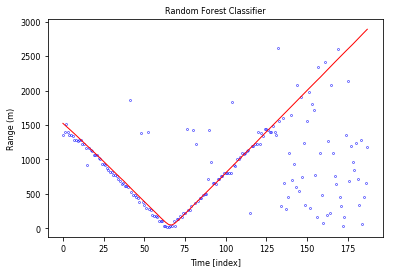

0.348126070563
beta =  5e-05 learning rate =  0.0001
('Epoch:', '0010', 'cost=', '2029.012522978')
('Epoch:', '0020', 'cost=', '1695.633465935')
('Epoch:', '0030', 'cost=', '1463.228135053')
('Epoch:', '0040', 'cost=', '1265.696719899')
('Epoch:', '0050', 'cost=', '1085.099099552')
('Epoch:', '0060', 'cost=', '923.511769014')
('Epoch:', '0070', 'cost=', '781.858638988')
training finished!
('accuarcy(train) =', 0.96158195)


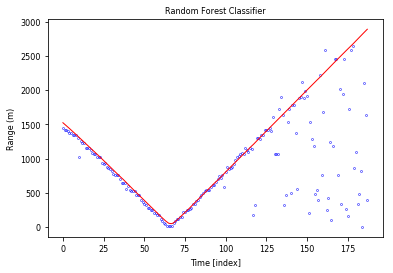

0.192059952657
beta =  5e-05 learning rate =  0.00025
('Epoch:', '0010', 'cost=', '1594.704237994')
('Epoch:', '0020', 'cost=', '1108.811272116')
('Epoch:', '0030', 'cost=', '754.420909208')
('Epoch:', '0040', 'cost=', '513.107899385')
('Epoch:', '0050', 'cost=', '358.966787899')
('Epoch:', '0060', 'cost=', '259.787529440')
('Epoch:', '0070', 'cost=', '199.697360768')
training finished!
('accuarcy(train) =', 0.96158195)


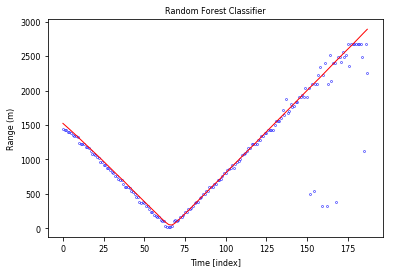

0.0851970817845
beta =  5e-05 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '1129.574290556')
('Epoch:', '0020', 'cost=', '548.148656509')
('Epoch:', '0030', 'cost=', '297.460210464')
('Epoch:', '0040', 'cost=', '190.466007008')
('Epoch:', '0050', 'cost=', '147.089253145')
('Epoch:', '0060', 'cost=', '127.348041310')
('Epoch:', '0070', 'cost=', '110.880948235')
training finished!
('accuarcy(train) =', 0.93559325)


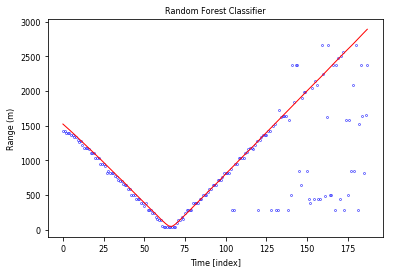

0.184679324931
beta =  5e-05 learning rate =  0.001
('Epoch:', '0010', 'cost=', '615.102122587')
('Epoch:', '0020', 'cost=', '241.823592242')
('Epoch:', '0030', 'cost=', '161.230758667')
('Epoch:', '0040', 'cost=', '131.543225905')
('Epoch:', '0050', 'cost=', '123.244164411')
('Epoch:', '0060', 'cost=', '107.788562999')
('Epoch:', '0070', 'cost=', '101.565373140')
training finished!
('accuarcy(train) =', 0.86101693)


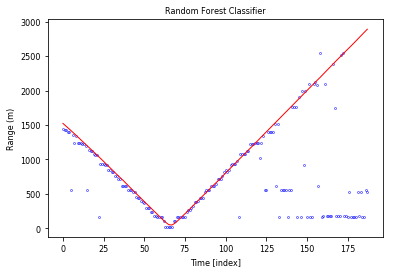

0.267784688538
beta =  0.0001 learning rate =  5e-05
('Epoch:', '0010', 'cost=', '4062.862778608')
('Epoch:', '0020', 'cost=', '3692.972785501')
('Epoch:', '0030', 'cost=', '3346.241067325')
('Epoch:', '0040', 'cost=', '3027.700769761')
('Epoch:', '0050', 'cost=', '2747.853903378')
('Epoch:', '0060', 'cost=', '2501.608355354')
('Epoch:', '0070', 'cost=', '2277.436135685')
training finished!
('accuarcy(train) =', 0.96045196)


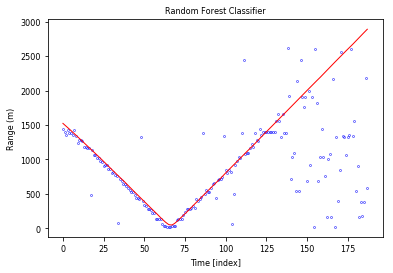

0.248311678654
beta =  0.0001 learning rate =  0.0001
('Epoch:', '0010', 'cost=', '3719.431970933')
('Epoch:', '0020', 'cost=', '3048.087445427')
('Epoch:', '0030', 'cost=', '2515.687428194')
('Epoch:', '0040', 'cost=', '2088.387034697')
('Epoch:', '0050', 'cost=', '1726.867539350')
('Epoch:', '0060', 'cost=', '1423.957914465')
('Epoch:', '0070', 'cost=', '1173.631354837')
training finished!
('accuarcy(train) =', 0.96158195)


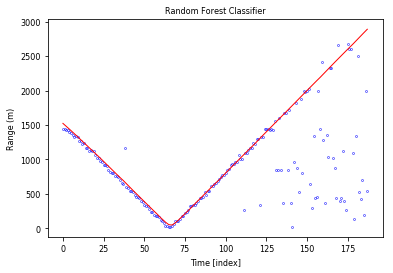

0.195665323269
beta =  0.0001 learning rate =  0.00025
('Epoch:', '0010', 'cost=', '2770.054041245')
('Epoch:', '0020', 'cost=', '1715.909431009')
('Epoch:', '0030', 'cost=', '1073.920927160')
('Epoch:', '0040', 'cost=', '691.354025448')
('Epoch:', '0050', 'cost=', '468.718522016')
('Epoch:', '0060', 'cost=', '338.050601735')
('Epoch:', '0070', 'cost=', '261.218398150')
training finished!
('accuarcy(train) =', 0.96158195)


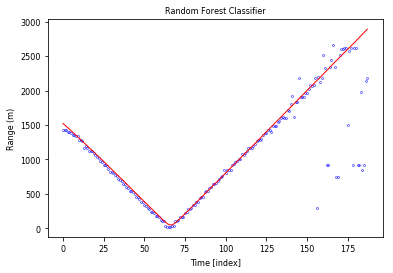

0.0969052981729
beta =  0.0001 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '1751.016737994')
('Epoch:', '0020', 'cost=', '727.637558881')
('Epoch:', '0030', 'cost=', '370.947868796')
('Epoch:', '0040', 'cost=', '245.224617453')
('Epoch:', '0050', 'cost=', '196.159274831')
('Epoch:', '0060', 'cost=', '171.229886223')
('Epoch:', '0070', 'cost=', '158.141877118')
training finished!
('accuarcy(train) =', 0.92542374)


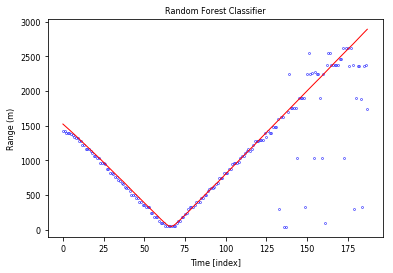

0.104877176022
beta =  0.0001 learning rate =  0.001
('Epoch:', '0010', 'cost=', '778.499827665')
('Epoch:', '0020', 'cost=', '285.301443661')
('Epoch:', '0030', 'cost=', '212.050867417')
('Epoch:', '0040', 'cost=', '178.188480153')
('Epoch:', '0050', 'cost=', '168.931428797')
('Epoch:', '0060', 'cost=', '154.488937378')
('Epoch:', '0070', 'cost=', '148.022095624')
training finished!
('accuarcy(train) =', 0.82033896)


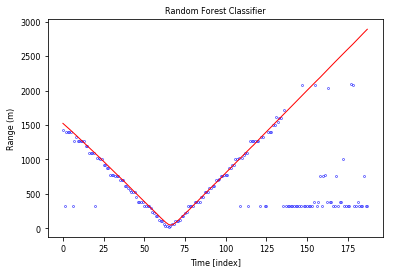

0.292058093194
beta =  0.0002 learning rate =  5e-05
('Epoch:', '0010', 'cost=', '7780.778176700')
('Epoch:', '0020', 'cost=', '6957.494111903')
('Epoch:', '0030', 'cost=', '6217.186925551')
('Epoch:', '0040', 'cost=', '5551.959357767')
('Epoch:', '0050', 'cost=', '4956.009018842')
('Epoch:', '0060', 'cost=', '4426.536075368')
('Epoch:', '0070', 'cost=', '3958.746854894')
training finished!
('accuarcy(train) =', 0.92429376)


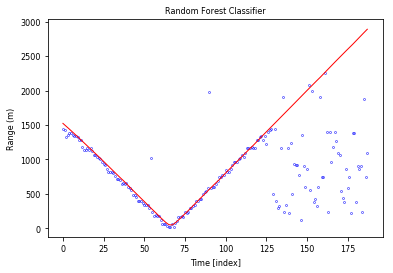

0.265088801977
beta =  0.0002 learning rate =  0.0001
('Epoch:', '0010', 'cost=', '6972.625890395')
('Epoch:', '0020', 'cost=', '5552.490808824')
('Epoch:', '0030', 'cost=', '4422.368652344')
('Epoch:', '0040', 'cost=', '3545.034007353')
('Epoch:', '0050', 'cost=', '2856.287712546')
('Epoch:', '0060', 'cost=', '2308.267333984')
('Epoch:', '0070', 'cost=', '1872.161886776')
training finished!
('accuarcy(train) =', 0.96158195)


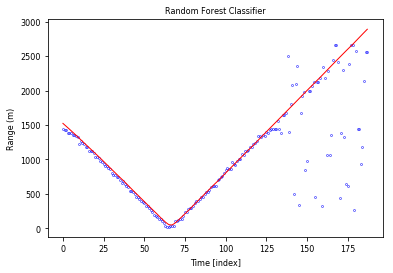

0.126040835522
beta =  0.0002 learning rate =  0.00025
('Epoch:', '0010', 'cost=', '5033.873448989')
('Epoch:', '0020', 'cost=', '2897.048943015')
('Epoch:', '0030', 'cost=', '1731.057538201')
('Epoch:', '0040', 'cost=', '1079.680678424')
('Epoch:', '0050', 'cost=', '714.128568761')
('Epoch:', '0060', 'cost=', '505.755992216')
('Epoch:', '0070', 'cost=', '384.109619141')
training finished!
('accuarcy(train) =', 0.95367229)


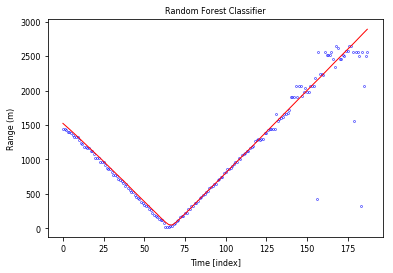

0.0703197035801
beta =  0.0002 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '2925.879207835')
('Epoch:', '0020', 'cost=', '1089.860768038')
('Epoch:', '0030', 'cost=', '519.164346134')
('Epoch:', '0040', 'cost=', '326.720907772')
('Epoch:', '0050', 'cost=', '260.800523646')
('Epoch:', '0060', 'cost=', '223.647829841')
('Epoch:', '0070', 'cost=', '211.569322474')
training finished!
('accuarcy(train) =', 0.82485878)


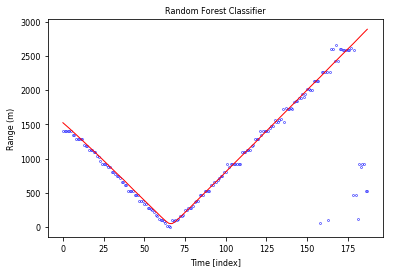

0.113987335323
beta =  0.0002 learning rate =  0.001
('Epoch:', '0010', 'cost=', '1095.587287454')
('Epoch:', '0020', 'cost=', '356.333531997')
('Epoch:', '0030', 'cost=', '260.295340145')
('Epoch:', '0040', 'cost=', '242.089894014')
('Epoch:', '0050', 'cost=', '216.560479557')
('Epoch:', '0060', 'cost=', '209.967174754')
('Epoch:', '0070', 'cost=', '203.237065932')
training finished!
('accuarcy(train) =', 0.70282483)


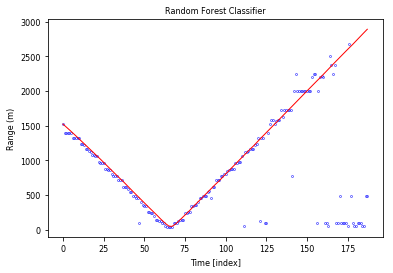

0.199672354185
beta =  0.0004 learning rate =  5e-05
('Epoch:', '0010', 'cost=', '15138.505629596')
('Epoch:', '0020', 'cost=', '13378.259478401')
('Epoch:', '0030', 'cost=', '11823.029239430')
('Epoch:', '0040', 'cost=', '10448.855296415')
('Epoch:', '0050', 'cost=', '9234.544347426')
('Epoch:', '0060', 'cost=', '8161.641802619')
('Epoch:', '0070', 'cost=', '7213.890797335')
training finished!
('accuarcy(train) =', 0.51751411)


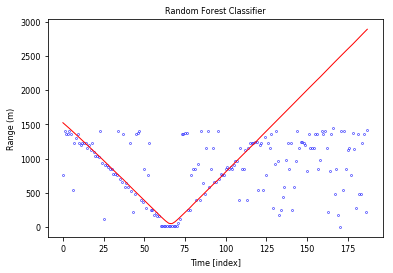

0.551595956338
beta =  0.0004 learning rate =  0.0001
('Epoch:', '0010', 'cost=', '13414.202320772')
('Epoch:', '0020', 'cost=', '10457.135569853')
('Epoch:', '0030', 'cost=', '8166.649902344')
('Epoch:', '0040', 'cost=', '6390.784294577')
('Epoch:', '0050', 'cost=', '5014.291733686')
('Epoch:', '0060', 'cost=', '3947.998118681')
('Epoch:', '0070', 'cost=', '3120.519157858')
training finished!
('accuarcy(train) =', 0.48813561)


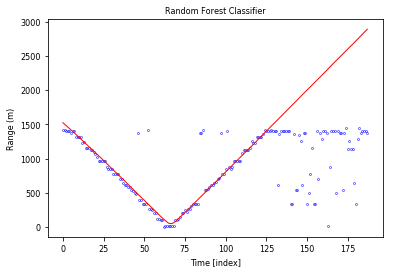

0.282442386709
beta =  0.0004 learning rate =  0.00025
('Epoch:', '0010', 'cost=', '9450.166704963')
('Epoch:', '0020', 'cost=', '5164.021685432')
('Epoch:', '0030', 'cost=', '2912.310058594')
('Epoch:', '0040', 'cost=', '1708.825066062')
('Epoch:', '0050', 'cost=', '1054.964172363')
('Epoch:', '0060', 'cost=', '696.035960478')
('Epoch:', '0070', 'cost=', '497.815585866')
training finished!
('accuarcy(train) =', 0.48926553)


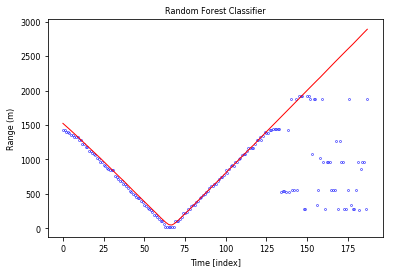

0.220201141376
beta =  0.0004 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '5180.448529412')
('Epoch:', '0020', 'cost=', '1681.298741958')
('Epoch:', '0030', 'cost=', '683.234866872')
('Epoch:', '0040', 'cost=', '385.346975888')
('Epoch:', '0050', 'cost=', '295.625459559')
('Epoch:', '0060', 'cost=', '266.095894309')
('Epoch:', '0070', 'cost=', '259.349126479')
training finished!
('accuarcy(train) =', 0.35141242)


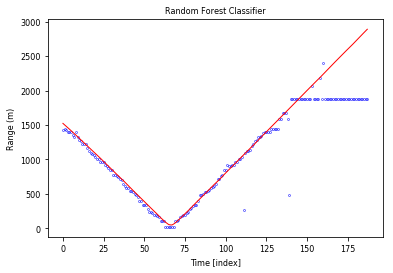

0.11169866455
beta =  0.0004 learning rate =  0.001
('Epoch:', '0010', 'cost=', '1687.556166705')
('Epoch:', '0020', 'cost=', '381.403955796')
('Epoch:', '0030', 'cost=', '279.925498514')
('Epoch:', '0040', 'cost=', '260.274166332')
('Epoch:', '0050', 'cost=', '258.497418572')
('Epoch:', '0060', 'cost=', '257.902946023')
('Epoch:', '0070', 'cost=', '247.654389325')
training finished!
('accuarcy(train) =', 0.24293785)


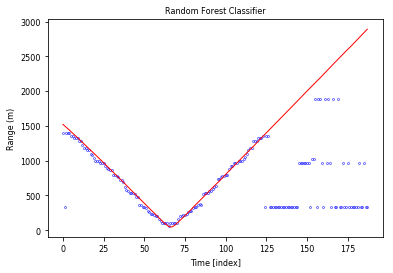

0.28684925078
beta =  0.0008 learning rate =  5e-05
('Epoch:', '0010', 'cost=', '29878.694738051')
('Epoch:', '0020', 'cost=', '26255.856962316')
('Epoch:', '0030', 'cost=', '23082.343750000')
('Epoch:', '0040', 'cost=', '20296.617761949')
('Epoch:', '0050', 'cost=', '17846.288947610')
('Epoch:', '0060', 'cost=', '15688.181927849')
('Epoch:', '0070', 'cost=', '13785.696174173')
training finished!
('accuarcy(train) =', 0.17627119)


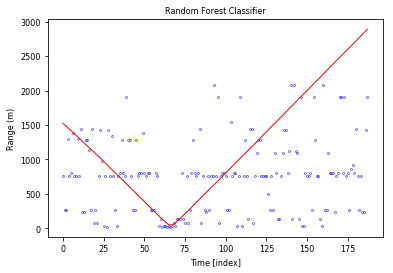

0.640230854908
beta =  0.0008 learning rate =  0.0001
('Epoch:', '0010', 'cost=', '26419.778377757')
('Epoch:', '0020', 'cost=', '20415.554917279')
('Epoch:', '0030', 'cost=', '15806.641716452')
('Epoch:', '0040', 'cost=', '12250.000804228')
('Epoch:', '0050', 'cost=', '9496.763786765')
('Epoch:', '0060', 'cost=', '7362.076861213')
('Epoch:', '0070', 'cost=', '5706.231904871')
training finished!
('accuarcy(train) =', 0.012429379)


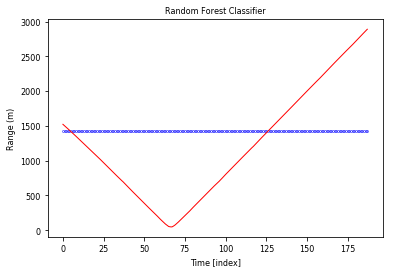

2.09775771317
beta =  0.0008 learning rate =  0.00025
('Epoch:', '0010', 'cost=', '18191.866498162')
('Epoch:', '0020', 'cost=', '9643.118221507')
('Epoch:', '0030', 'cost=', '5179.111730239')
('Epoch:', '0040', 'cost=', '2826.495734720')
('Epoch:', '0050', 'cost=', '1586.917839499')
('Epoch:', '0060', 'cost=', '937.075105555')
('Epoch:', '0070', 'cost=', '598.889066808')
training finished!
('accuarcy(train) =', 0.013559322)


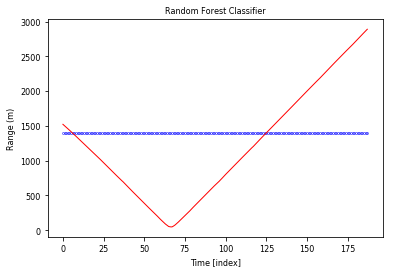

2.06430169665
beta =  0.0008 learning rate =  0.0005
('Epoch:', '0010', 'cost=', '9781.784926471')
('Epoch:', '0020', 'cost=', '2866.942440257')
('Epoch:', '0030', 'cost=', '970.428664264')
('Epoch:', '0040', 'cost=', '446.137431425')
('Epoch:', '0050', 'cost=', '301.759201947')
('Epoch:', '0060', 'cost=', '262.433171889')
('Epoch:', '0070', 'cost=', '251.899629481')
training finished!
('accuarcy(train) =', 0.013559322)


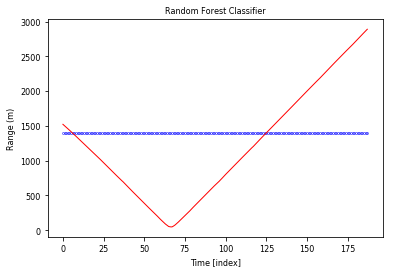

2.06430169665
beta =  0.0008 learning rate =  0.001
('Epoch:', '0010', 'cost=', '2886.812945198')
('Epoch:', '0020', 'cost=', '447.807094798')
('Epoch:', '0030', 'cost=', '263.666397992')
('Epoch:', '0040', 'cost=', '249.411353616')
('Epoch:', '0050', 'cost=', '248.310888851')
('Epoch:', '0060', 'cost=', '248.224768246')
('Epoch:', '0070', 'cost=', '248.220882640')
training finished!
('accuarcy(train) =', 0.013559322)


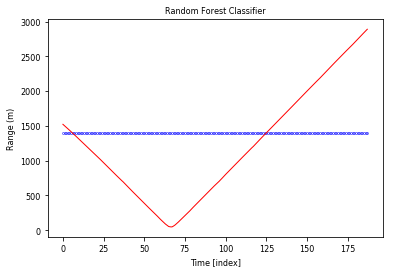

2.06430169665


In [191]:
for beta in [0.00001, 0.00005, 0.0001, 0.0002, 0.0004, 0.0008]:
    for learning_rate in [0.00005, 0.0001, 0.00025,0.0005, 0.001]:
        print 'beta = ', beta, 'learning rate = ', learning_rate
        def train_nn3(data):
            pred, reg = nn_model3(data, beta)
            cost = tf.reduce_sum(-y*tf.log(tf.clip_by_value(pred,1e-11,1.0)) + reg)
            #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
            #    logits = pred, labels = y))

            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

            # Test model
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            # Calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            epochs = n_eps

            with tf.Session() as sess:
                tf.global_variables_initializer().run()
                #prev_loss = None

                for epoch in range(epochs):
                    avg_cost = 0
                    total_batch = int(X_train2.shape[0] / batch_size)

                    # Training
                    for i in range(total_batch):
                        xb = X_train2[i * batch_size : (i + 1) * batch_size]
                        yb = y_train[i * batch_size : (i + 1) * batch_size]
                        _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                        avg_cost += c / total_batch

                    if (epoch+1) % disp_step == 0:
                        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
                    if math.isnan(avg_cost):
                        break
                    #prev_loss = loss
                print 'training finished!'
                predictions = sess.run(pred, feed_dict = {x: X_test2})


                print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
            return predictions

        pred3 = train_nn3(x)
        Z=np.argmax(pred3,1)
        Z_out = Range_train[Z.astype(np.int32)]

        plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
        plt.plot(Y_test,'r',linewidth=1.0)

        plt.xlabel('Time [index]',fontsize=8)
        plt.ylabel('Range (m)',fontsize=8)
        plt.tick_params(axis='both', which='major', labelsize=8)
        plt.tick_params(axis='both', which='minor', labelsize=8)
        plt.title('Random Forest Classifier',fontsize=8)

        plt.show()
        print MAPE(Z_out, Y_test)

_optimal params_:  
beta = 0.0002  learning rate = 0.00025

In [194]:
y_train.shape

(885, 144)

#### Try different number of neurons

n_h1 =  512 beta =  1e-06
('Epoch:', '0010', 'cost=', '65.070330452')
('Epoch:', '0020', 'cost=', '47.382104313')
('Epoch:', '0030', 'cost=', '32.085843142')
('Epoch:', '0040', 'cost=', '20.926546882')
('Epoch:', '0050', 'cost=', '131.318467757')
('Epoch:', '0060', 'cost=', '28.177743126')
('Epoch:', '0070', 'cost=', '19.967288073')
training finished!
('accuarcy(train) =', 0.96158195)


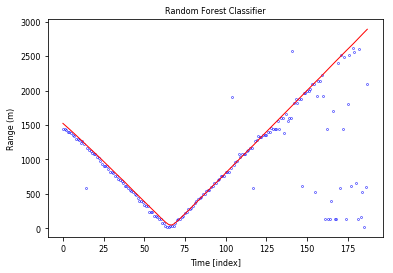

0.156573604798
n_h1 =  1024 beta =  1e-06
('Epoch:', '0010', 'cost=', '123.736430897')
('Epoch:', '0020', 'cost=', '85.418278862')
('Epoch:', '0030', 'cost=', '54.135231467')
('Epoch:', '0040', 'cost=', '32.764431224')
('Epoch:', '0050', 'cost=', '48.493082047')
('Epoch:', '0060', 'cost=', '45.122886882')
('Epoch:', '0070', 'cost=', '29.519104004')
training finished!
('accuarcy(train) =', 0.96158195)


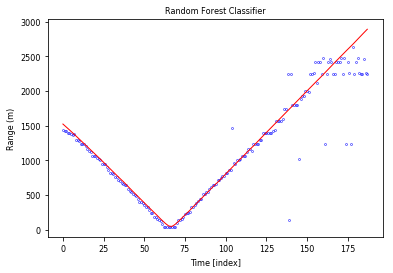

0.0878993795988
n_h1 =  512 beta =  3e-06
('Epoch:', '0010', 'cost=', '138.649993896')
('Epoch:', '0020', 'cost=', '62.604824739')
('Epoch:', '0030', 'cost=', '67.982636844')
('Epoch:', '0040', 'cost=', '35.215839610')
('Epoch:', '0050', 'cost=', '16.902938057')
('Epoch:', '0060', 'cost=', '12.415505802')
('Epoch:', '0070', 'cost=', '45.941791086')
training finished!
('accuarcy(train) =', 0.95706213)


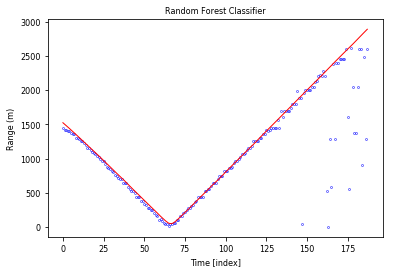

0.0981127180635
n_h1 =  1024 beta =  3e-06
('Epoch:', '0010', 'cost=', '264.644937852')
('Epoch:', '0020', 'cost=', '113.680619184')
('Epoch:', '0030', 'cost=', '107.503530615')
('Epoch:', '0040', 'cost=', '42.496608959')
('Epoch:', '0050', 'cost=', '27.147201762')
('Epoch:', '0060', 'cost=', '42.824949152')
('Epoch:', '0070', 'cost=', '26.961411308')
training finished!
('accuarcy(train) =', 0.94689268)


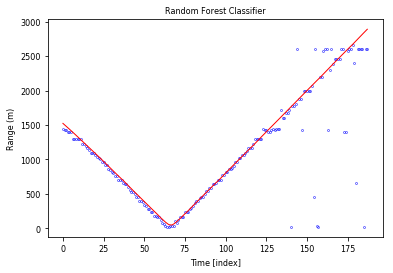

0.101185857216
n_h1 =  512 beta =  1e-05
('Epoch:', '0010', 'cost=', '193.407170913')
('Epoch:', '0020', 'cost=', '77.587974100')
('Epoch:', '0030', 'cost=', '39.837461135')
('Epoch:', '0040', 'cost=', '50.423896565')
('Epoch:', '0050', 'cost=', '37.025069405')
('Epoch:', '0060', 'cost=', '39.512130513')
('Epoch:', '0070', 'cost=', '40.451262081')
training finished!
('accuarcy(train) =', 0.92655367)


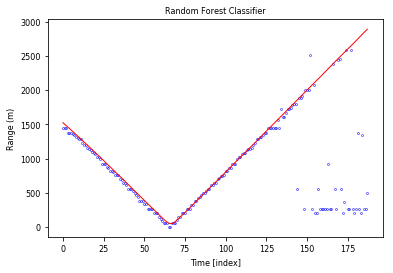

0.192563812603
n_h1 =  1024 beta =  1e-05
('Epoch:', '0010', 'cost=', '322.450995950')
('Epoch:', '0020', 'cost=', '101.488835503')
('Epoch:', '0030', 'cost=', '56.496299295')
('Epoch:', '0040', 'cost=', '64.047957701')
('Epoch:', '0050', 'cost=', '56.721629648')
('Epoch:', '0060', 'cost=', '45.034577762')
('Epoch:', '0070', 'cost=', '46.553925683')
training finished!
('accuarcy(train) =', 0.92316383)


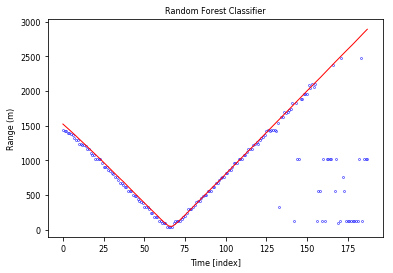

0.185346437105
n_h1 =  512 beta =  3e-05
('Epoch:', '0010', 'cost=', '152.091132669')
('Epoch:', '0020', 'cost=', '84.940087711')
('Epoch:', '0030', 'cost=', '82.764261582')
('Epoch:', '0040', 'cost=', '84.680598988')
('Epoch:', '0050', 'cost=', '85.621028676')
('Epoch:', '0060', 'cost=', '80.461414562')
('Epoch:', '0070', 'cost=', '81.414889167')
training finished!
('accuarcy(train) =', 0.88248587)


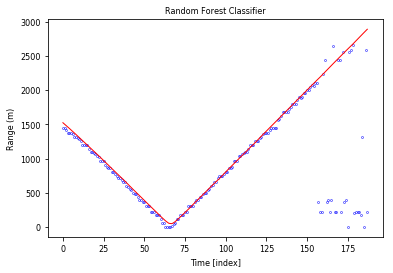

0.166373035239
n_h1 =  1024 beta =  3e-05
('Epoch:', '0010', 'cost=', '217.653349933')
('Epoch:', '0020', 'cost=', '107.367971532')
('Epoch:', '0030', 'cost=', '92.637874379')
('Epoch:', '0040', 'cost=', '85.508362714')
('Epoch:', '0050', 'cost=', '88.887309355')
('Epoch:', '0060', 'cost=', '89.771595226')
('Epoch:', '0070', 'cost=', '86.259920457')
training finished!
('accuarcy(train) =', 0.85649717)


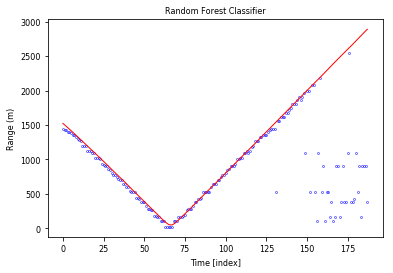

0.197374272142
n_h1 =  512 beta =  0.0001
('Epoch:', '0010', 'cost=', '184.621835148')
('Epoch:', '0020', 'cost=', '162.092915254')
('Epoch:', '0030', 'cost=', '164.538321102')
('Epoch:', '0040', 'cost=', '165.217974494')
('Epoch:', '0050', 'cost=', '162.818559534')
('Epoch:', '0060', 'cost=', '162.537856158')
('Epoch:', '0070', 'cost=', '157.722458783')
training finished!
('accuarcy(train) =', 0.84858757)


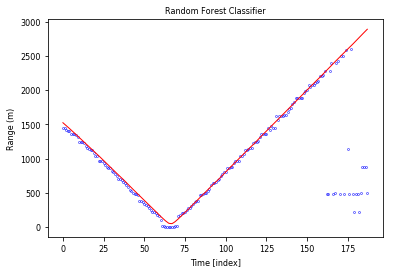

0.160068807413
n_h1 =  1024 beta =  0.0001
('Epoch:', '0010', 'cost=', '220.232048483')
('Epoch:', '0020', 'cost=', '166.808033663')
('Epoch:', '0030', 'cost=', '171.484261905')
('Epoch:', '0040', 'cost=', '169.014332491')
('Epoch:', '0050', 'cost=', '168.827380910')
('Epoch:', '0060', 'cost=', '168.742607565')
('Epoch:', '0070', 'cost=', '165.177512674')
training finished!
('accuarcy(train) =', 0.8237288)


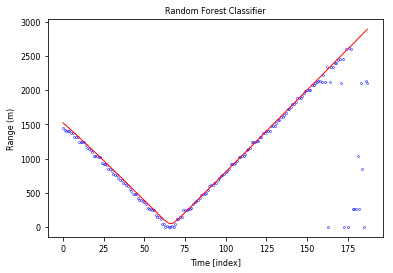

0.125835786439


In [18]:
for beta in [0.000001, 0.000003, 0.00001, 0.00003, 0.0001]:
    for n_h1 in [512, 1024]:
        print 'n_h1 = ', n_h1, 'beta = ', beta
        n_in = X_train2.shape[1]
        n_cls = y_train.shape[1]
        x = tf.placeholder(tf.float32, [None, n_in])
        y = tf.placeholder(tf.float32, [None, n_cls])

        def nn_model1(data, beta):
            W1 = init_weights((n_in, n_h1))
            b1 = tf.Variable(tf.zeros([n_h1]))

            Wout = init_weights((n_h1, n_cls))
            bout = tf.Variable(tf.zeros([n_cls]))

            l1 = tf.matmul(data, W1) + b1
            l1 = tf.nn.relu(l1)

            pred = tf.nn.softmax(tf.matmul(l1, Wout) + bout)
            reg = beta*tf.nn.l2_loss(W1) + \
                beta*tf.nn.l2_loss(b1) + \
                beta*tf.nn.l2_loss(Wout) + \
                beta*tf.nn.l2_loss(bout)

            return pred, reg

        batch_size = 50
        n_eps = 75
        disp_step = 10
        learning_rate = 0.0025

        def train_nn1(data):
            pred, reg = nn_model1(data, beta)
            cost = tf.reduce_sum(-y*tf.log(tf.clip_by_value(pred,1e-11,1.0)) + reg)

            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

            # Test model
            correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            # Calculate accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            epochs = n_eps

            with tf.Session() as sess:
                tf.global_variables_initializer().run()
                #prev_loss = None

                for epoch in range(epochs):
                    avg_cost = 0
                    total_batch = int(X_train2.shape[0] / batch_size)

                    # Training
                    for i in range(total_batch):
                        xb = X_train2[i * batch_size : (i + 1) * batch_size]
                        yb = y_train[i * batch_size : (i + 1) * batch_size]
                        _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                        avg_cost += c / total_batch

                    if (epoch+1) % disp_step == 0:
                        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
                    if math.isnan(avg_cost):
                        break
                    #prev_loss = loss
                print 'training finished!'
                predictions = sess.run(pred, feed_dict = {x: X_test2})


                print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
            return predictions

        pred1 = train_nn1(x)
        Z=np.argmax(pred1,1)
        Z_out = Range_train[Z.astype(np.int32)]

        plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
        plt.plot(Y_test,'r',linewidth=1.0)

        plt.xlabel('Time [index]',fontsize=8)
        plt.ylabel('Range (m)',fontsize=8)
        plt.tick_params(axis='both', which='major', labelsize=8)
        plt.tick_params(axis='both', which='minor', labelsize=8)
        plt.title('Random Forest Classifier',fontsize=8)

        plt.show()
        print MAPE(Z_out, Y_test)

### Plot the learning curve

('Epoch:', '0010', 'cost=', '53.566544028')
('Epoch:', '0020', 'cost=', '49.299339070')
('Epoch:', '0030', 'cost=', '44.464576721')
('Epoch:', '0040', 'cost=', '39.213569192')
('Epoch:', '0050', 'cost=', '33.846893984')
('Epoch:', '0060', 'cost=', '28.620610069')
('Epoch:', '0070', 'cost=', '23.731173123')
('Epoch:', '0080', 'cost=', '19.315187454')
('Epoch:', '0090', 'cost=', '15.456315321')
('Epoch:', '0100', 'cost=', '12.187800351')
training finished!
('accuarcy(train) =', 0.95505619)


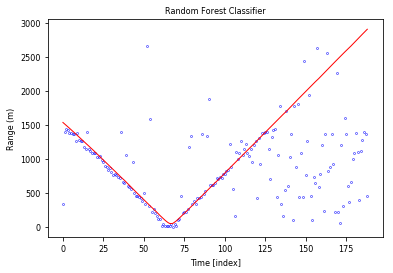

0.409942722787


In [86]:
n_h1 = 256
beta = 0.000001
n_in = X_train2.shape[1]
n_cls = y_train.shape[1]
x = tf.placeholder(tf.float32, [None, n_in])
y = tf.placeholder(tf.float32, [None, n_cls])

def nn_model1(data, beta):
    W1 = init_weights((n_in, n_h1))
    b1 = tf.Variable(tf.zeros([n_h1]))

    Wout = init_weights((n_h1, n_cls))
    bout = tf.Variable(tf.zeros([n_cls]))

    l1 = tf.matmul(data, W1) + b1
    l1 = tf.nn.relu(l1)

    pred = tf.nn.softmax(tf.matmul(l1, Wout) + bout)
    reg = beta*tf.nn.l2_loss(W1) + \
        beta*tf.nn.l2_loss(b1) + \
        beta*tf.nn.l2_loss(Wout) + \
        beta*tf.nn.l2_loss(bout)

    return pred, reg

batch_size = 50
n_eps = 100
disp_step = 10
learning_rate = 0.001
losses = []
mapes = []
mapes2 = []
probs = []

def train_nn1(data):
    pred, reg = nn_model1(data, beta)
    cost = tf.reduce_sum(-y*tf.log(tf.clip_by_value(pred,1e-11,1.0)) + reg)

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    epochs = n_eps

    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        #prev_loss = None

        for epoch in range(epochs):
            avg_cost = 0
            total_batch = int(X_train2.shape[0] / batch_size)

            # Training
            for i in range(total_batch):
                xb = X_train2[i * batch_size : (i + 1) * batch_size]
                yb = y_train[i * batch_size : (i + 1) * batch_size]
                _, c = sess.run([optimizer, cost], feed_dict = {x: xb, y: yb})
                avg_cost += c / total_batch

            if (epoch+1) % disp_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            if math.isnan(avg_cost):
                break
            
            # save prediction MAPE on test set
            predictions = sess.run(pred, feed_dict = {x: X_test2})
            
            
            Z=np.argmax(predictions,1)
            Z_out = Range_train[Z.astype(np.int32)]
            mapes.append(MAPE(Z_out, Y_test))
            # save prediction MAPE on training set
            predictions2 = sess.run(pred, feed_dict = {x: X_train2})
            Z=np.argmax(predictions2,1)
            Z_out = Range_train[Z.astype(np.int32)]
            mapes2.append(MAPE(Z_out, Y_train2))
            
            # save average cost / losses
            losses.append(avg_cost)
            
            # save predictions probability:
            if epoch in [0 ,50, 99]:
                probs.append(predictions[1, :])
            
            
            
            #prev_loss = loss
        print 'training finished!'
        predictions = sess.run(pred, feed_dict = {x: X_test2})


        print("accuarcy(train) =",sess.run(accuracy, feed_dict={x:X_train2, y: y_train}))
    return predictions

pred1 = train_nn1(x)
Z=np.argmax(pred1,1)
Z_out = Range_train[Z.astype(np.int32)]

plt.plot(Z_out,"o",markersize=2,markeredgewidth=0.5,markeredgecolor='b',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)

plt.xlabel('Time [index]',fontsize=8)
plt.ylabel('Range (m)',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title('Random Forest Classifier',fontsize=8)

plt.show()
print MAPE(Z_out, Y_test)

In [87]:
len(losses)

100

In [88]:
len(probs)

3

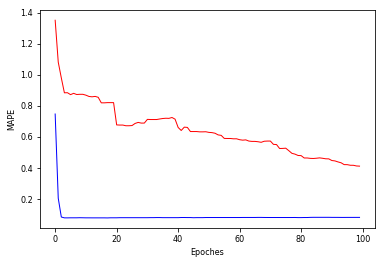

In [89]:
plt.plot(mapes,'r',linewidth=1.0)
plt.plot(mapes2, 'b', linewidth = 1.0)

plt.xlabel('Epoches',fontsize=8)
plt.ylabel('MAPE',fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()

### Output probability

In [84]:
truth = np.zeros([144])
truth[71] = 1

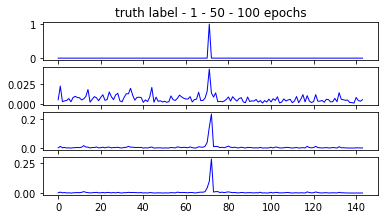

In [85]:
ax = plt.subplot(511)
ax.set_title("truth label - 1 - 50 - 100 epochs")
plt.plot(truth, 'b', linewidth = 1.0)

ax = plt.subplot(512)
plt.plot(probs[0], 'b', linewidth = 1.0)

ax = plt.subplot(513)
plt.plot(probs[1], 'b', linewidth = 1.0)

ax = plt.subplot(514)
plt.plot(probs[2], 'b', linewidth = 1.0)

plt.show()